# Gaussian Quadrature for Financial Mathematics

This notebook explores the theoretical foundations and implementation of Gaussian quadrature methods and Laguerre polynomial roots calculation.

In [8]:
# Module reloading cell - run this cell to refresh modules after code changes
import sys
import os
import importlib
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt 
import math

# Add project root to Python path to ensure imports work correctly
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Direct imports from module paths
from src.gaussian_quadrature.utils import quadrature as quad
from src.gaussian_quadrature.models import bachelier as bach

# Function to reload modules
def reload_modules():
    importlib.reload(quad)
    importlib.reload(bach)
    print("Modules reloaded successfully!")

# Run this when you need to refresh the modules
reload_modules()

Modules reloaded successfully!


# Gaussian Quadrature for Financial Mathematics

This notebook explores the theoretical foundations and implementation of Gaussian quadrature methods.
## 1. Introduction to Gaussian Quadrature

Gaussian quadrature is a numerical integration technique that approximates definite integrals using a weighted sum:

$$\int_a^b f(x)w(x)dx \approx \sum_{i=1}^n w_i f(x_i)$$

where:
- $w(x)$ is a weight function
- $x_i$ are the quadrature points (nodes)
- $w_i$ are the quadrature weights


### Gauss-Laguerre Quadrature

For our caplet pricing, we use Gauss-Laguerre quadrature, which is specialized for integrals of the form:

$$\int_0^\infty f(x)e^{-x}dx \approx \sum_{i=1}^n w_i f(x_i)$$

The nodes $x_i$ are the roots of the nth Laguerre polynomial $L_n(x)$, and the weights are given by:

$$w_i = \frac{(n!)^2}{x_i[L_{n+1}(x_i)]^2}$$

## 2. Laguerre Polynomials

The Laguerre polynomials are essential for Gauss-Laguerre quadrature. They satisfy the recurrence relation:

$$L_{n+1}(x) = \frac{(2n + 1 - x)L_n(x) - nL_{n-1}(x)}{n + 1}$$

Let's first look at the explicit representation of these polynomials:

### 2.1 Explicit Representation of Laguerre Polynomials

The Laguerre polynomials can be represented in several equivalent forms. While we've been using a recurrence relation for computational efficiency, it's instructive to examine their explicit representation, especially when verifying correctness.

The explicit formula for the $n$-th Laguerre polynomial is:

$$L_n(x) = \sum_{k=0}^n \binom{n}{k} \frac{(-1)^k}{k!} x^k = \frac{1}{n!}\left((-x)^n + \frac{n^2}{1!}(-x)^{n-1} + \ldots + \frac{n!}{n!}\right)$$

Let's use our newly added function to display the explicit form of several Laguerre polynomials:

In [2]:
# Reload the module to ensure we get the latest version of the function
#reload_modules()

# Display explicit forms of the first few Laguerre polynomials
for n in range(6):  # L_0 to L_5
    print(quad.print_laguerre_polynomial(n))
    print("")

L_0(x) = 1

L_1(x) = 1/1 * (-x + 1)

L_2(x) = 1/2 * (x^2 -4*x + 2)

L_3(x) = 1/6 * (-x^3 + 9*x^2 -18*x + 6)

L_4(x) = 1/24 * (x^4 -16*x^3 + 72*x^2 -96*x + 24)

L_5(x) = 1/120 * (-x^5 + 25*x^4 -200*x^3 + 600*x^2 -600*x + 120)



### 2.1 Visual Representation of Laguerre Polynomials

Now let's visualize these polynomials using both static (matplotlib) and interactive (plotly) plots:

In [3]:
# Import needed functions directly from quadrature module
from src.gaussian_quadrature.utils.quadrature import (
    laguerre_polynomial,
    laguerre_function_scaled,
    print_laguerre_polynomial,
    get_laguerre_coefficients
)
import plotly.graph_objects as go

# Generate points for visualization
x = jnp.linspace(0, 10, 200)

# Compute polynomial values for degrees 0 to 5
polynomials = {}
for n in range(6):
    polynomials[f'L_{n}'] = laguerre_polynomial(n, x)

# Create interactive Plotly visualization instead of matplotlib
fig = go.Figure()

# Color palette for different polynomial degrees
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']

# Add traces for each polynomial
for n, (name, values) in enumerate(polynomials.items()):
    fig.add_trace(go.Scatter(
        x=x,
        y=values,
        name=name,
        mode='lines',
        line=dict(width=2, color=colors[n % len(colors)])
    ))

# Add zeros/roots for each polynomial as vertical lines
for n in range(1, 6):  # Skip L_0 as it has no roots
    # Find zeros approximately by looking for sign changes
    y_vals = polynomials[f'L_{n}']
    zeros = []
    for i in range(1, len(y_vals)):
        if y_vals[i-1] * y_vals[i] <= 0:  # Sign change detected
            # Approximate zero position using linear interpolation
            t = -y_vals[i-1] / (y_vals[i] - y_vals[i-1])
            zero_x = x[i-1] + t * (x[i] - x[i-1])
            zeros.append(zero_x)
    
    # Add vertical lines at zeros
    for zero in zeros:
        fig.add_shape(
            type="line",
            x0=zero,
            y0=-4,
            x1=zero,
            y1=4,
            line=dict(color=colors[n % len(colors)], width=1, dash="dash"),
            opacity=0.4,
            name=f"Root of L_{n}"
        )

# Update layout with title, labels, and grid
fig.update_layout(
    title="Interactive Laguerre Polynomials",
    xaxis_title="x",
    yaxis_title="L_n(x)",
    legend_title="Polynomial",
    hovermode="closest",
    height=600,
    width=900,
    plot_bgcolor='rgba(240, 240, 240, 0.8)',  # Light gray background
    xaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.5)',
        zerolinewidth=2,
        zerolinecolor='rgba(0, 0, 0, 0.2)',
        range=[-5, 10]
    ),
    yaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.5)',
        zerolinewidth=2,
        zerolinecolor='rgba(0, 0, 0, 0.2)',
        range=[-10, 10]
    )
)

# Add annotations to explain the roots
fig.add_annotation(
    x=1.5, 
    y=3.5,
    text="Vertical dashed lines indicate<br>the roots of each polynomial",
    showarrow=False,
    bgcolor="rgba(255, 255, 255, 0.8)"
)

fig.show()

### 2.1.1 Interactive Comparison Across Multiple Degrees

Let's create an interactive visualization to examine Laguerre polynomials across multiple degrees:

In [3]:
# Create an interactive plot with sliders to explore different degrees
x = np.linspace(0, 15, 200)

# Create traces for different degrees
fig = go.Figure()

# Add initial trace for degree 0
fig.add_trace(
    go.Scatter(
        visible=True,
        line=dict(color="blue", width=3),
        name=f"L_0(x)",
        x=x,
        y=laguerre_polynomial(0, x)
    )
)

# Add traces for degrees 1 to 10, but make them invisible initially
for n in range(1, 11):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="blue", width=3),
            name=f"L_{n}(x)",
            x=x,
            y=laguerre_polynomial(n, x)
        )
    )

# Create and add slider
steps = []
for i in range(11):
    step = dict(
        method="update",
        args=[
            {"visible": [False] * 11},
            {"title": f"Laguerre Polynomial L_{i}(x)"}
        ],
        label=str(i)
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to visible
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Degree: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title="Interactive Laguerre Polynomial Explorer",
    xaxis_title="x",
    yaxis_title="L_n(x)",
    height=600,
    width=900,
    yaxis=dict(range=[-10, 10]),  # Set reasonable y-axis limits
    hovermode="closest"
)

# Add annotation explaining how to use the slider
fig.add_annotation(
    x=12, 
    y=8,
    text="Use the slider below to change<br>the degree of the polynomial",
    showarrow=False,
    bgcolor="rgba(255, 255, 255, 0.8)"
)

fig.show()

### 2.2.1 Mathematical Properties of Laguerre Polynomials

Laguerre polynomials $L_n(x)$ form a complete orthogonal system on $[0, \infty)$ with respect to the weight function $w(x) = e^{-x}$. They satisfy the orthogonality relation:

$$\int_0^\infty L_m(x) L_n(x) e^{-x} dx = \delta_{mn}$$

where $\delta_{mn}$ is the Kronecker delta.

#### Key Properties:

1. **Explicit formula**: The $n$-th Laguerre polynomial can be expressed as:
   $$L_n(x) = \sum_{k=0}^n \binom{n}{k} \frac{(-1)^k}{k!} x^k$$

2. **Generating function**: Laguerre polynomials have the generating function:
   $$\frac{e^{-xt/(1-t)}}{1-t} = \sum_{n=0}^\infty L_n(x) t^n, \quad |t| < 1$$

3. **Differential equation**: They satisfy the differential equation:
   $$x y'' + (1-x) y' + n y = 0$$

4. **Rodrigues' formula**:
   $$L_n(x) = \frac{e^x}{n!} \frac{d^n}{dx^n}(x^n e^{-x})$$

5. **Zeros**: All $n$ zeros of $L_n(x)$ are real, simple, and lie in the interval $(0, \infty)$.

### 2.2.2 Numerical Stability Considerations

Computing Laguerre polynomials using the standard recurrence relation can lead to numerical instability for large $n$ or $x$. In our implementation, we've incorporated several stability improvements:

1. **Scaling of recurrence relation**: We scale the recurrence relation to avoid overflow/underflow:
   $$L_{n+1}(x) = \frac{1}{n+1}[(2n+1-x)L_n(x) - nL_{n-1}(x)]$$

2. **Handling of exponential terms**: We use $L_n(x)e^{-x/2}$ instead of $L_n(x)$ directly to balance the exponential weight.

3. **Adaptive scaling for large $x$**: When $x$ is large, we apply additional scaling factors.

#### The `laguerre_function_final` Implementation:

Our implementation in `laguerre_function_final` incorporates these stability improvements to compute both the polynomial values and their derivatives reliably across a wide range of inputs.

### 2.2.3 Connection to Financial Mathematics

In financial mathematics, particularly for derivative pricing, we often encounter integrals of the form:

$$\int_0^\infty f(x) e^{-x} dx$$

These integrals appear when computing expectations under certain probability measures, especially when working with normally distributed variables transformed through exponential functions (as in the Bachelier model for interest rate derivatives).

Laguerre polynomials are particularly well-suited for approximating these integrals because:

1. They form an orthogonal basis with respect to the $e^{-x}$ weight function.
2. The zeros of $L_n(x)$ (which become our quadrature points) are optimally distributed for capturing the behavior of integrands with exponential decay.
3. They allow for efficient handling of semi-infinite integration domains $[0, \infty)$.

In our caplet pricing application, the Laguerre quadrature helps us accurately compute option values where the payoff structure, combined with normal distribution terms from the Bachelier model, creates integrands that are particularly well-approximated using this approach.

### 2.4 Comparing Different Representations

There are two main ways to represent Laguerre polynomials:

1. **Explicit Formula (Rodrigues' Formula)**:
   
   The Laguerre polynomials can be defined by Rodrigues' formula:
   
   $$L_n(x) = \frac{e^x}{n!} \frac{d^n}{dx^n}(x^n e^{-x})$$
   
   This explicit form gives a direct way to compute any Laguerre polynomial of degree $n$. However, evaluating high-order derivatives can be computationally expensive and numerically unstable for large $n$.

2. **Recurrence Relation**:
   
   The Laguerre polynomials also satisfy a three-term recurrence relation:
   
   $$L_{n+1}(x) = \frac{(2n + 1 - x)L_n(x) - nL_{n-1}(x)}{n+1}$$
   
   with initial conditions $L_0(x) = 1$ and $L_1(x) = 1 - x$.

Let's compare these two approaches for computing Laguerre polynomials:

In [12]:
import pandas as pd
from scipy.special import eval_laguerre  # Import SciPy's Laguerre polynomial function

def explicit_laguerre(n, x):
    """Calculate Laguerre polynomial values using the explicit formula"""
    coeffs = get_laguerre_coefficients(n)
    result = np.zeros_like(x)
    for k, coeff in enumerate(coeffs):
        result += coeff * x**k
    return result

# Compare for a specific degree
n = 10
x_values = jnp.linspace(0, 15, 100)

# Compute values using different methods
explicit_values = explicit_laguerre(n, x_values)
recurrence_values = laguerre_polynomial(n, x_values)
scaled_values, _ = laguerre_function_scaled(n, x_values)
scipy_values = eval_laguerre(n, x_values)  # SciPy implementation

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'x': x_values,
    'Explicit Formula': explicit_values,
    'Recurrence Relation': recurrence_values,
    'Scaled Implementation': scaled_values,
    'SciPy Implementation': scipy_values  # Added SciPy values
})

# Display first few rows
print(f"Comparison of different implementations for L_{n}(x):")
display(comparison_df.head())

# Calculate differences
comparison_df['Explicit-Recurrence Diff'] = np.abs(comparison_df['Explicit Formula'] - comparison_df['Recurrence Relation'])
comparison_df['Explicit-Scaled Diff'] = np.abs(comparison_df['Explicit Formula'] - comparison_df['Scaled Implementation'])
comparison_df['Explicit-SciPy Diff'] = np.abs(comparison_df['Explicit Formula'] - comparison_df['SciPy Implementation'])  # Added SciPy comparison

# Display max differences
max_diff_recurrence = comparison_df['Explicit-Recurrence Diff'].max()
max_diff_scaled = comparison_df['Explicit-Scaled Diff'].max()
max_diff_scipy = comparison_df['Explicit-SciPy Diff'].max()  # Added SciPy max diff
print(f"\nMaximum absolute difference between Explicit and Recurrence: {max_diff_recurrence:.2e}")
print(f"Maximum absolute difference between Explicit and Scaled: {max_diff_scaled:.2e}")
print(f"Maximum absolute difference between Explicit and SciPy: {max_diff_scipy:.2e}")  # Added SciPy diff output

Comparison of different implementations for L_10(x):


,x,Explicit Formula,Recurrence Relation,Scaled Implementation,SciPy Implementation
0,0.000000,1.000000,1.000000,0.015047,1.000000
1,0.151515,-0.063742,-0.063741,0.008586,-0.063742
2,0.303030,-0.452080,-0.452080,0.003250,-0.452080
3,0.454545,-0.439727,-0.439727,-0.000842,-0.439727
4,0.606061,-0.225814,-0.225814,-0.003700,-0.225815



Maximum absolute difference between Explicit and Recurrence: 3.00e-01
Maximum absolute difference between Explicit and Scaled: 2.40e+02
Maximum absolute difference between Explicit and SciPy: 3.00e-01


### 2.5 Root-Finding Algorithms for Laguerre Polynomials

Finding accurate roots of Laguerre polynomials is crucial for Gaussian quadrature, as these roots become the quadrature points. We'll compare several methods for computing these roots:

1. **Basic Iterative Method**: Uses Newton's method with simple initial guesses
2. **Scaled Iterative Method**: Uses improved initial guesses and scaling for better stability
3. **Eigenvalue Method**: Exploits the connection between polynomial roots and eigenvalues of tridiagonal matrices
4. **SciPy's Implementation**: Serves as our reference

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.special import roots_laguerre
import jax.numpy as jnp
from scipy.linalg import eigh_tridiagonal

from src.gaussian_quadrature.utils.quadrature import (
    compute_gauss_laguerre_points_basic,
    compute_gauss_laguerre_points_scaled,
    compute_gauss_laguerre_points_eigenvalue,
    get_laguerre_coefficients
)

def find_roots_laguerre_eigenvalue(n, alpha=0.0):
    """
    Find roots of Laguerre polynomial using the eigenvalue method.
    """
    # For Laguerre polynomials, the recurrence coefficients are:
    # a_i = 2*i + 1 + alpha
    # b_i = sqrt(i * (i + alpha))
    
    if n <= 0:
        return np.array([])
    
    # Create the diagonal elements
    diag = np.array([2*i + 1 + alpha for i in range(n)])
    
    # Create the off-diagonal elements
    off_diag = np.array([np.sqrt(i * (i + alpha)) for i in range(1, n)])
    
    # Find eigenvalues (these are the roots)
    roots = eigh_tridiagonal(diag, off_diag, eigvals_only=True)
    
    return np.sort(roots)

def compare_laguerre_roots(n_points):
    """Compare Laguerre roots computed by different methods."""
    # Get roots from different methods
    basic_roots, basic_weights = compute_gauss_laguerre_points_basic(n_points)
    scaled_roots, scaled_weights = compute_gauss_laguerre_points_scaled(n_points)
    eigen_roots, eigen_weights = compute_gauss_laguerre_points_eigenvalue(n_points)
    scipy_roots, scipy_weights = roots_laguerre(n_points)
    
    # Convert to numpy arrays for easier handling
    basic_roots = np.array(basic_roots)
    scaled_roots = np.array(scaled_roots)
    eigen_roots = np.array(eigen_roots)
    
    # Sort all roots for fair comparison
    basic_roots = np.sort(basic_roots)
    scaled_roots = np.sort(scaled_roots)
    eigen_roots = np.sort(eigen_roots)
    scipy_roots = np.sort(scipy_roots)
    
    # Calculate differences from scipy
    basic_diff = np.abs(basic_roots - scipy_roots)
    scaled_diff = np.abs(scaled_roots - scipy_roots)
    eigen_diff = np.abs(eigen_roots - scipy_roots)
    
    print(f"\nComparing Laguerre roots for n={n_points}:")
    print(f"Basic method max difference:   {np.max(basic_diff):.8e}")
    print(f"Scaled method max difference:  {np.max(scaled_diff):.8e}")
    print(f"Eigenvalue method difference:  {np.max(eigen_diff):.8e}")
    
    return basic_roots, scaled_roots, eigen_roots, scipy_roots

def plot_roots_comparison(n_points):
    """Plot the roots from different methods for visual comparison."""
    basic_roots, scaled_roots, eigen_roots, scipy_roots = compare_laguerre_roots(n_points)
    
    plt.figure(figsize=(12, 6))
    
    # Create a y-position for each method
    methods = ['Basic', 'Scaled', 'Eigenvalue', 'SciPy']
    y_positions = [1, 2, 3, 4]
    
    # Plot roots on horizontal lines
    plt.plot(basic_roots, [y_positions[0]]*len(basic_roots), 'bo', label='Basic Method')
    plt.plot(scaled_roots, [y_positions[1]]*len(scaled_roots), 'go', label='Scaled Method')
    plt.plot(eigen_roots, [y_positions[2]]*len(eigen_roots), 'ro', label='Eigenvalue Method')
    plt.plot(scipy_roots, [y_positions[3]]*len(scipy_roots), 'ks', label='SciPy (Reference)')
    
    # Add vertical lines for SciPy roots for easier comparison
    for root in scipy_roots:
        plt.axvline(x=root, color='k', linestyle='--', alpha=0.2)
    
    plt.yticks(y_positions, methods)
    plt.xlabel('Root Value')
    plt.title(f'Comparison of Laguerre Polynomial Roots (n={n_points})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



Comparing Laguerre roots for n=50:
Basic method max difference:   1.18511260e+02
Scaled method max difference:  1.33952998e+02
Eigenvalue method difference:  7.31808308e-06


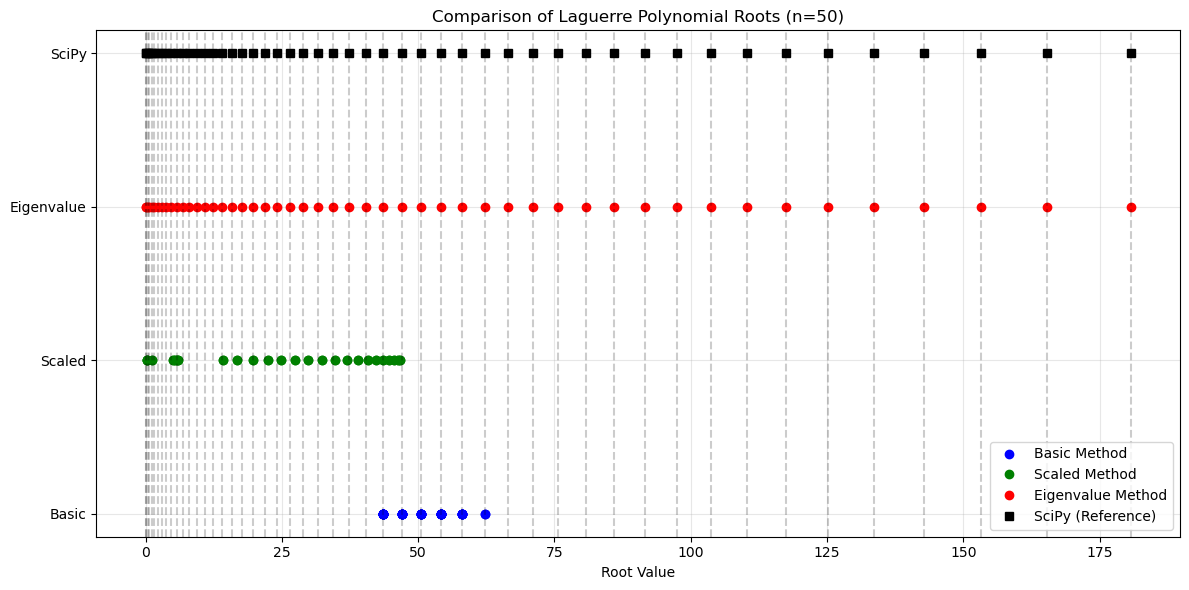

In [15]:
# Compare roots for different n values
for n in [50]:
    plot_roots_comparison(n)

### 2.5.1 Performance Benchmarking of Root-Finding Methods

Now let's benchmark the performance of different methods for finding the roots of Laguerre polynomials across various degrees:

In [16]:
from numpy.polynomial.polynomial import polyroots

def find_roots_laguerre_numpy(n):
    """Find roots of Laguerre polynomial using NumPy's polyroots."""
    # For standard Laguerre polynomials (alpha=0), use our coefficients function
    coeffs = get_laguerre_coefficients(n)
    # Reverse for polyroots (it expects highest power first)
    coeffs = coeffs[::-1]
    roots = polyroots(coeffs)
    
    # Filter out complex roots or roots with small imaginary part
    real_roots = np.array([root.real for root in roots if abs(root.imag) < 1e-10])
    return np.sort(real_roots)

def benchmark_methods(degrees):
    """Benchmark different root-finding methods."""
    methods = {
        'Basic': lambda n: compute_gauss_laguerre_points_basic(n)[0],
        'Scaled': lambda n: compute_gauss_laguerre_points_scaled(n)[0],
        'Eigenvalue': lambda n: compute_gauss_laguerre_points_eigenvalue(n)[0],
        'NumPy Poly': lambda n: find_roots_laguerre_numpy(n),
        'SciPy': lambda n: roots_laguerre(n)[0]
    }
    
    results = {name: [] for name in methods}
    timings = {name: [] for name in methods}
    
    for n in degrees:
        print(f"Processing degree {n}...")
        
        for name, method in methods.items():
            try:
                start_time = time.time()
                roots = method(n)
                end_time = time.time()
                
                results[name].append(roots)
                timings[name].append(end_time - start_time)
                
                print(f"  {name}: Found {len(roots)} roots in {end_time - start_time:.6f} seconds")
            except Exception as e:
                print(f"  {name}: Error - {str(e)}")
                results[name].append([])
                timings[name].append(np.nan)
    
    return results, timings

def compute_max_errors(results, reference_method='SciPy'):
    """Compute maximum errors between methods and a reference method."""
    methods = list(results.keys())
    errors = {name: [] for name in methods if name != reference_method}
    
    for i in range(len(results[reference_method])):
        ref_roots = results[reference_method][i]
        
        if len(ref_roots) == 0:
            continue
            
        for name in methods:
            if name == reference_method:
                continue
                
            method_roots = results[name][i]
            
            if len(method_roots) == 0:
                errors[name].append(np.nan)
            elif len(method_roots) != len(ref_roots):
                print(f"Warning: {name} found {len(method_roots)} roots, but {reference_method} found {len(ref_roots)}")
                errors[name].append(np.nan)
            else:
                max_error = np.max(np.abs(np.sort(method_roots) - np.sort(ref_roots)))
                errors[name].append(max_error)
    
    return errors

def plot_benchmark_results(degrees, results, timings, errors):
    """Plot benchmark results."""
    plt.figure(figsize=(18, 12))
    
    # Plot 1: Example roots distribution for a specific degree
    plt.subplot(2, 2, 1)
    example_idx = min(2, len(degrees)-1)  # Use a sensible degree for example
    example_n = degrees[example_idx]
    
    for name, method_results in results.items():
        if len(method_results) > example_idx and len(method_results[example_idx]) > 0:
            roots = method_results[example_idx]
            plt.plot(roots, np.zeros_like(roots), 'o', label=f"{name} (n={example_n})")
    
    plt.title(f"Laguerre polynomial roots distribution (n={example_n})")
    plt.xlabel("x")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Execution time comparison
    plt.subplot(2, 2, 2)
    
    for name, method_timings in timings.items():
        plt.plot(degrees, method_timings, 'o-', label=name)
    
    plt.title("Execution time comparison")
    plt.xlabel("Polynomial degree (n)")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot 3: Maximum error comparison
    plt.subplot(2, 2, 3)
    
    for name, method_errors in errors.items():
        plt.plot(degrees, method_errors, 'o-', label=name)
    
    plt.title("Maximum absolute error compared to SciPy")
    plt.xlabel("Polynomial degree (n)")
    plt.ylabel("Maximum error")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    # Plot 4: Number of roots found by each method
    plt.subplot(2, 2, 4)
    
    for name, method_results in results.items():
        num_roots = [len(roots) for roots in method_results]
        plt.plot(degrees, num_roots, 'o-', label=name)
    
    plt.title("Number of roots found")
    plt.xlabel("Polynomial degree (n)")
    plt.ylabel("Number of roots")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Benchmarking Laguerre polynomial root finding methods...

Processing degree 3...
  Basic: Found 3 roots in 1.198793 seconds
  Basic: Found 3 roots in 1.198793 seconds
  Scaled: Found 3 roots in 1.043761 seconds
  Scaled: Found 3 roots in 1.043761 seconds
  Eigenvalue: Found 3 roots in 0.305612 seconds
  NumPy Poly: Found 3 roots in 0.000000 seconds
  SciPy: Found 3 roots in 0.000000 seconds
Processing degree 5...
  Eigenvalue: Found 3 roots in 0.305612 seconds
  NumPy Poly: Found 3 roots in 0.000000 seconds
  SciPy: Found 3 roots in 0.000000 seconds
Processing degree 5...
  Basic: Found 5 roots in 2.379584 seconds
  Basic: Found 5 roots in 2.379584 seconds
  Scaled: Found 5 roots in 0.224922 seconds
  Eigenvalue: Found 5 roots in 0.005002 seconds
  NumPy Poly: Found 5 roots in 0.000000 seconds
  SciPy: Found 5 roots in 0.000000 seconds
Processing degree 10...
  Scaled: Found 5 roots in 0.224922 seconds
  Eigenvalue: Found 5 roots in 0.005002 seconds
  NumPy Poly: Found 5 roots in 0.000

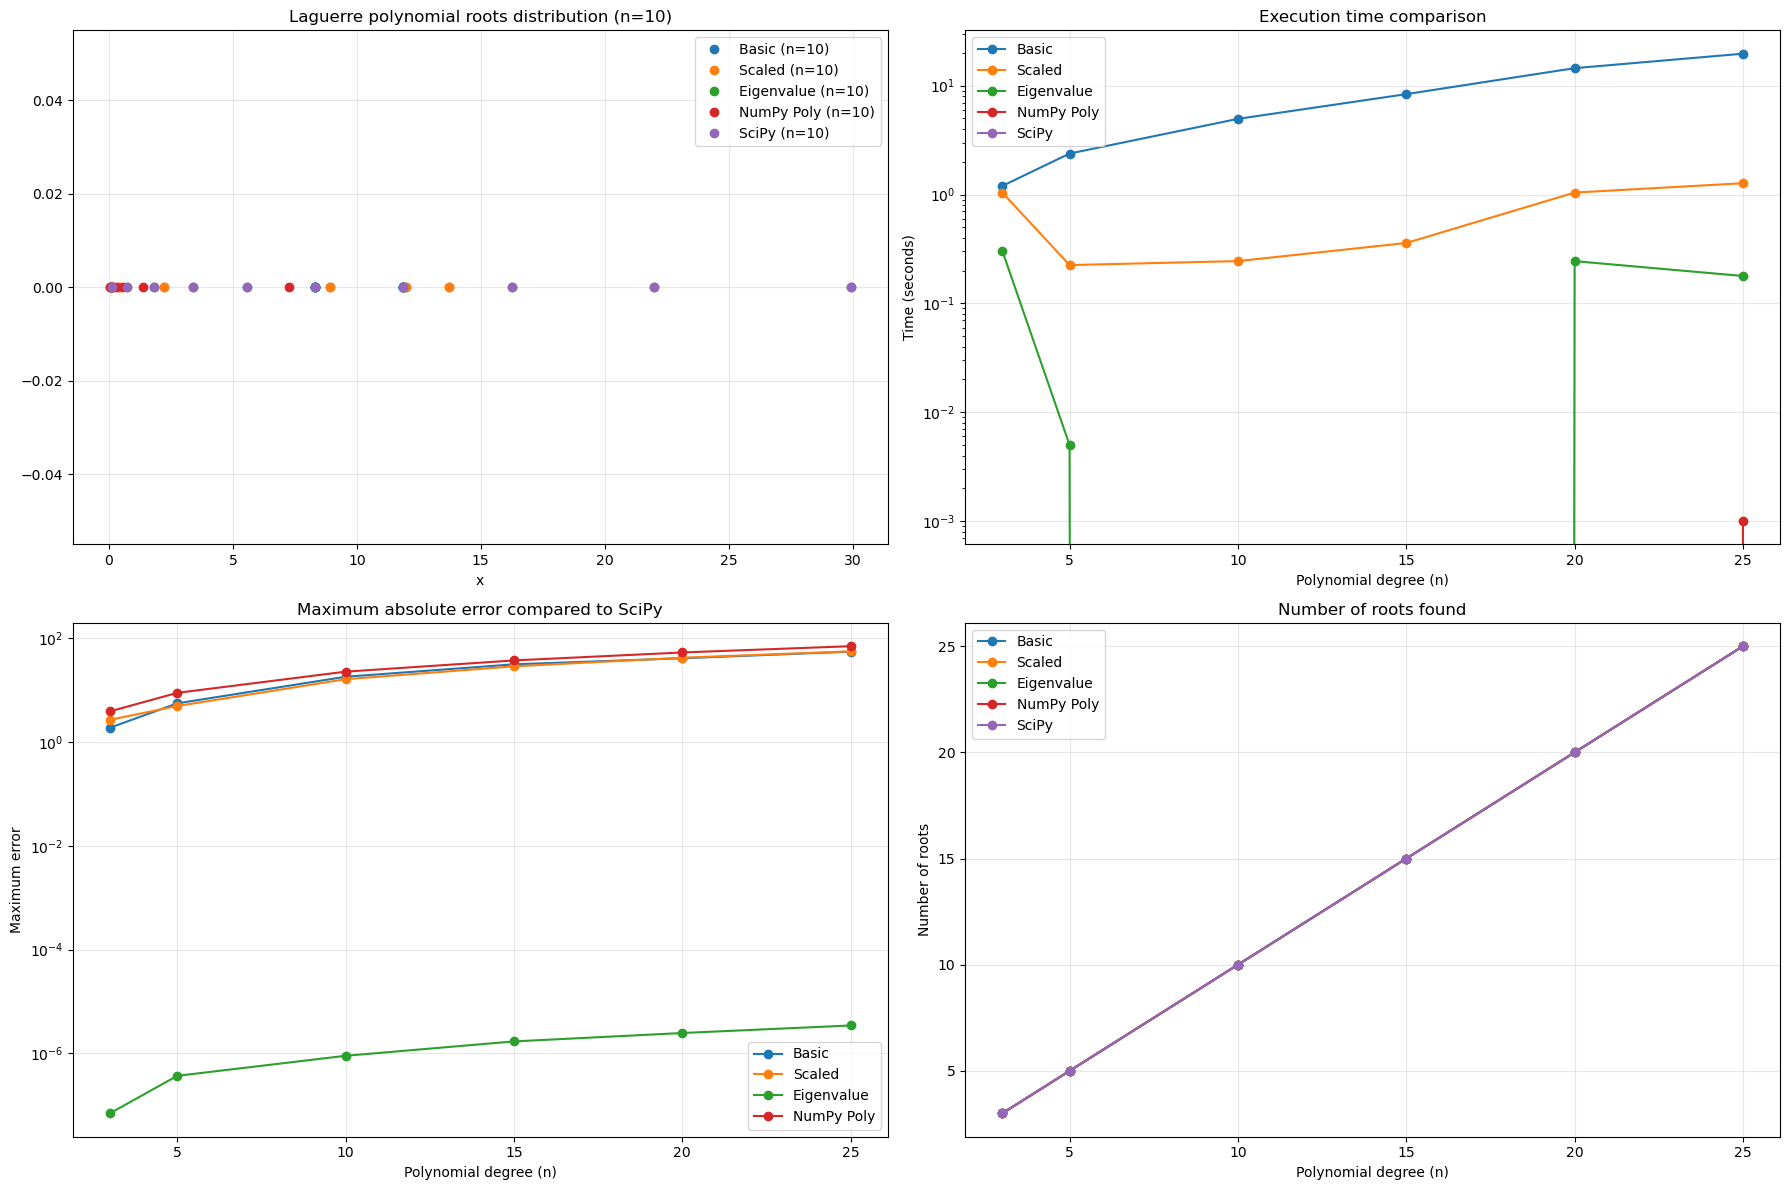

In [10]:
# Define degrees to test
degrees = [3, 5, 10, 15, 20, 25]

# Run the benchmark
print("Benchmarking Laguerre polynomial root finding methods...\n")
results, timings = benchmark_methods(degrees)

# Compute errors compared to SciPy's implementation
errors = compute_max_errors(results, reference_method='SciPy')

# Plot results
plot_benchmark_results(degrees, results, timings, errors)

## 3. Quadrature Points and Weights

For Gauss-Laguerre quadrature, we need to find:
1. The roots of the nth Laguerre polynomial (quadrature points)
2. The corresponding weights

Let's compute and visualize these:

In [17]:
n_points = 5 
nodes, weights = quad.compute_gauss_laguerre_points_final(n_points)

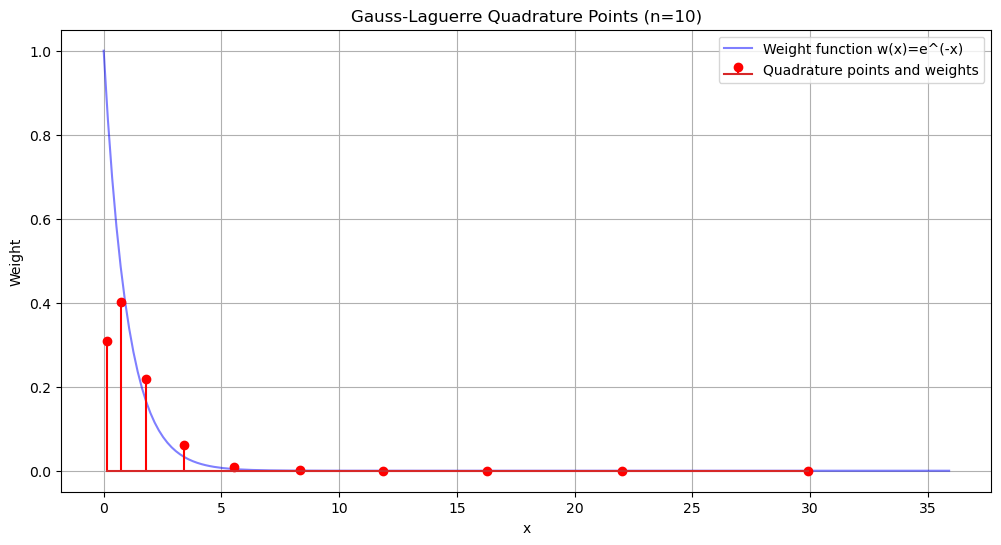

In [18]:
def plot_quadrature_points(n_points=5):
    # Compute nodes and weights
    nodes, weights = quad.compute_gauss_laguerre_points_final(n_points)
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Plot weight function e^(-x)
    x = jnp.linspace(0, max(nodes) * 1.2, 200)
    plt.plot(x, jnp.exp(-x), 'b-', label='Weight function w(x)=e^(-x)', alpha=0.5)
    
    # Plot quadrature points and weights
    plt.stem(nodes, weights, 'r', label='Quadrature points and weights')
    
    plt.title(f'Gauss-Laguerre Quadrature Points (n={n_points})')
    plt.xlabel('x')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    plt.show()

    return nodes, weights

nodes, weights = plot_quadrature_points(10)

### 3.2 Interactive Visualization of Gaussian Quadrature Convergence

This section provides an interactive visualization that demonstrates how the accuracy of Gaussian quadrature integration improves with an increasing number of quadrature points (n).

We'll use the function $f(x) = x$ as our example, which has the analytical solution $\int_0^\infty e^{-x} \cdot x dx = 1$.

The visualization will show:
1. The actual integrand function $f(x) \cdot w(x) = x*e^{-x}$
2. The quadrature points (nodes) and weights as vertical bars
3. How the approximation improves as n increases
4. The error compared to the analytical solution

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from ipywidgets import interact, IntSlider

def interactive_gauss_laguerre_demo(n_points=5):
    # Compute nodes and weights using our Gauss-Laguerre quadrature function
    nodes, weights = quad.compute_gauss_laguerre_points_final(n_points)
    
    # Function to integrate: f(x) = x
    # When multiplied by weight w(x) = e^(-x), we get x*e^(-x)
    f = lambda x: x
    
    # Our example function evaluated at quadrature points
    f_values = f(nodes)
    
    # Compute the quadrature approximation
    approx = np.sum(weights * f_values)
    
    # The analytical solution for the integral of x*e^(-x) from 0 to infinity is 1
    exact = 1
    error = np.abs(approx - exact)
    rel_error = error / exact * 100  # percentage error
    
    # Create x values for plotting the integrand, limiting x to 25
    x_plot = np.linspace(0, 25, 500)
    integrand = x_plot * np.exp(-x_plot)  # x * e^(-x)
    
    # Create a subplot with 2 rows
    fig = make_subplots(rows=2, cols=1, 
                         subplot_titles=('Gaussian Quadrature Approximation', 'Error Convergence'),
                         row_heights=[0.7, 0.3],
                         specs=[[{"type": "scatter"}], [{"type": "scatter"}]],
                         vertical_spacing=0.15)
    
    # Add the integrand function x*e^(-x) to the first subplot
    fig.add_trace(
        go.Scatter(
            x=x_plot,
            y=integrand,
            mode='lines',
            line=dict(color='blue', width=2),
            name='f(x)·w(x) = x*e^(-x)',
            fill='tozeroy',
            fillcolor='rgba(0, 0, 255, 0.1)'
        ), row=1, col=1
    )
    
    # Add vertical bars representing quadrature points and their weights
    for i in range(n_points):
        # Make rectangle width equal to the weight, centered at the node
        rect_width = weights[i]
        # Height is just the function value at the node
        height = f_values[i]
        
        # Add vertical rectangles that represent the quadrature points and their contribution
        fig.add_shape(
            type="rect",
            x0=nodes[i] - rect_width/2,  # Left edge: node - half width
            y0=0,
            x1=nodes[i] + rect_width/2,  # Right edge: node + half width
            y1=height,
            line=dict(width=1, color='rgba(255, 0, 0, 0.6)'),
            fillcolor='rgba(255, 0, 0, 0.4)',
            name=f'Node {i+1}',
            row=1,
            col=1
        )
        
        # Add text annotations for weights
        fig.add_annotation(
            x=nodes[i],
            y=height + 0.02,
            text=f"w={weights[i]:.4f}",
            showarrow=False,
            font=dict(size=10),
            row=1,
            col=1
        )
    
    # Add annotations for results
    fig.add_annotation(
        x=0.95,
        y=0.95,
        text=f"<b>Results for n={n_points}:</b><br>" + 
             f"Approximation = {approx:.6f}<br>" + 
             f"Exact = {exact:.6f}<br>" + 
             f"Error = {error:.6f} ({rel_error:.4f}%)",
        showarrow=False,
        font=dict(size=12),
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
        xref="paper",
        yref="paper",
        align="left"
    )
    
    # Add a point showing the exact solution on the plot
    fig.add_trace(
        go.Scatter(
            x=[0],
            y=[exact],
            mode='markers',
            marker=dict(size=10, color='green'),
            name='Exact solution (1)'
        ), row=1, col=1
    )
    
    # Add data for second subplot (error convergence)
    n_values = list(range(1, 16))  # Show errors for n=1 to n=15
    errors = []
    
    for n in n_values:
        n_nodes, n_weights = quad.compute_gauss_laguerre_points_final(n)
        n_f_values = f(n_nodes)
        n_approx = np.sum(n_weights * n_f_values)
        errors.append(np.abs(n_approx - exact))
    
    # Add error convergence plot
    fig.add_trace(
        go.Scatter(
            x=n_values,
            y=errors,
            mode='lines+markers',
            name='Error',
            line=dict(color='red', width=2)
        ), row=2, col=1
    )
    
    # Highlight the current n value in the error plot
    if n_points <= 15:
        fig.add_trace(
            go.Scatter(
                x=[n_points],
                y=[errors[n_points-1]],
                mode='markers',
                marker=dict(size=12, color='green', symbol='circle-open'),
                name='Current n'
            ), row=2, col=1
        )
    
    # Update layout
    fig.update_layout(
        title=f"Gaussian-Laguerre Quadrature for ∫₀^∞ e^(-x) · x dx with {n_points} points",
        width=900,
        height=700,
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        hovermode="closest"
    )
    
    # Update axis labels and limit x-axis to 25
    fig.update_xaxes(title_text="x", row=1, col=1, range=[0, 25])
    fig.update_yaxes(title_text="f(x)·w(x) = x*e^(-x)", row=1, col=1)
    fig.update_xaxes(title_text="Number of quadrature points (n)", row=2, col=1)
    fig.update_yaxes(title_text="Error", type="log", row=2, col=1)
    
    return fig

# Create an interactive widget
interact(
    interactive_gauss_laguerre_demo,
    n_points=IntSlider(min=1, max=50, step=1, value=5, description='Points (n):', style={'description_width': '100px'})
);

interactive(children=(IntSlider(value=5, description='Points (n):', max=50, min=1, style=SliderStyle(descripti…

In [20]:
# Interactive visualization of Gaussian quadrature with f(x) = x*e^(-x)
import plotly.graph_objects as go
import numpy as np

def f(x):
    """Our target function: f(x) = x * e^(-x)"""
    return x * np.exp(-x)

# Create a dense set of points for accurate curve plotting
x_dense = np.linspace(0, 25, 500)

### 3.2.1 Weight Sum Demonstration - Geometric Interpretation

For Gauss-Laguerre quadrature, the weights have a geometric interpretation. When $f(x) = 1$, the quadrature formula approximates $\int_0^\infty e^{-x} dx = 1$.

We can visualize this by showing how rectangles with:
- heights equal to 1 (since $f(x) = 1$)
- widths represented by the weights $w_i$
- positioned at the nodes $x_i$

The sum of these rectangles' areas approximates the area under the curve $e^{-x}$ from 0 to infinity.

In [14]:
import plotly.express as px


def visualize_weight_rectangles():
    """
    Visualize how Gauss-Laguerre quadrature weights represent rectangles that
    approximate the function e^(-x), with the sum of rectangle areas matching
    the integral of e^(-x) from 0 to infinity (which equals 1).
    """
    # Create plots for different numbers of points
    n_values = [3, 5, 10, 15]
    
    # Create subplots
    fig = make_subplots(rows=2, cols=2, 
                       subplot_titles=[f"n={n} points" for n in n_values],
                       shared_xaxes=True, shared_yaxes=True)
    
    # Define the exact function e^(-x)
    x_dense = np.linspace(0, 15, 1000)
    y_dense = np.exp(-x_dense)
    
    # Color for the exact function curve
    curve_color = 'rgba(0, 0, 255, 0.8)'
    
    # Process each subplot
    for i, n in enumerate(n_values):
        row = i // 2 + 1
        col = i % 2 + 1
        
        # Compute Gauss-Laguerre nodes and weights
        nodes, weights = quad.compute_gauss_laguerre_points_final(n)
        
        # Add the exact function curve
        fig.add_trace(
            go.Scatter(
                x=x_dense,
                y=y_dense,
                mode='lines',
                line=dict(color=curve_color, width=2),
                name='e^(-x)' if (row == 1 and col == 1) else None,
                showlegend=(row == 1 and col == 1)
            ), row=row, col=col
        )
        
        # Calculate the total sum of weights for this n
        weight_sum = np.sum(weights)
        
        # Colors for rectangles - use a colorscale
        colors = px.colors.sequential.Viridis
        color_indices = np.linspace(0, len(colors)-1, n)
        rect_colors = [colors[int(i)] for i in color_indices]
        
        # Add rectangles for each quadrature point
        for j, (node, weight) in enumerate(zip(nodes, weights)):
            # For f(x) = 1, we're showing rectangles with height 1 and width w_i
            # positioned at x_i values
            
            # Rectangle extends from x=node to width represented by weight
            rect_x = [node, node, node + weight, node + weight, node]
            rect_y = [0, 1, 1, 0, 0]  # height is 1 since f(x) = 1
            
            # Add rectangle as a filled shape
            fig.add_trace(
                go.Scatter(
                    x=rect_x,
                    y=rect_y,
                    fill='toself',
                    fillcolor=f'rgba{tuple(int(c) for c in hex_to_rgb(rect_colors[j])) + (0.5,)}',
                    line=dict(color=rect_colors[j]),
                    name=f"Point {j+1}: w={weight:.4f}" if (row == 1 and col == 1 and j < 5) else None,
                    showlegend=(row == 1 and col == 1 and j < 5)  # Only show legend for first subplot and first 5 points
                ), row=row, col=col
            )
            
            # Mark the node position with a dot
            fig.add_trace(
                go.Scatter(
                    x=[node],
                    y=[0],
                    mode='markers',
                    marker=dict(size=8, color=rect_colors[j]),
                    showlegend=False
                ), row=row, col=col
            )
        
        # Add text annotation with sum of weights
        fig.add_annotation(
            x=0.95, y=0.95,
            text=f"Sum of weights: {weight_sum:.8f}",
            xref=f"x{row+col-1}", yref=f"y{row+col-1}",
            xanchor='right', yanchor='top',
            showarrow=False,
            font=dict(size=12, color='black', family='Arial'),
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='rgba(0, 0, 0, 0.5)',
            borderwidth=1,
            borderpad=4
        )
    
    # Update layout
    fig.update_layout(
        title="Geometric Interpretation: How Gauss-Laguerre weights approximate ∫e^(-x)dx with rectangles",
        height=700,
        width=1000,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        )
    )
    
    # Update x and y axes limits and titles
    for i in range(1, 5):
        fig.update_xaxes(range=[0, 15], title_text="x" if i > 2 else None, row=(i-1)//2+1, col=(i-1)%2+1)
        fig.update_yaxes(range=[0, 1.1], title_text="e^(-x)" if i % 2 == 1 else None, row=(i-1)//2+1, col=(i-1)%2+1)
    
    fig.show()
    
    # Display a summary table of the results
    results = []
    for n in n_values:
        nodes, weights = quad.compute_gauss_laguerre_points_final(n)
        weight_sum = np.sum(weights)
        error = abs(weight_sum - 1.0)
        results.append([n, weight_sum, error])
    
    table_fig = go.Figure(data=[go.Table(
        header=dict(
            values=['Number of Points (n)', 'Sum of Weights', 'Error from Exact Value (1.0)'],
            fill_color='paleturquoise',
            align='center'
        ),
        cells=dict(
            values=list(zip(*results)),
            fill_color='lavender',
            align='center',
            format=[None, '.10f', '.10f']
        )
    )])
    

# Helper function to convert hex color to RGB
def hex_to_rgb(hex_color):
    """Convert hex color to RGB tuple"""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Run the visualization
visualize_weight_rectangles()

## 4. Verification of Gaussian Quadrature Methods

In this section, we'll verify the accuracy and efficiency of different Gaussian quadrature methods by comparing them against:

1. SciPy's numerical integration methods
2. Taylor series approximations

We'll particularly focus on evaluating the Gauss-Laguerre quadrature implementations for weighted integrals of the form:

$$\int_0^\infty f(x) x^\alpha e^{-x} dx$$

### 4.1 Direct Verification Against SciPy's Implementation

Now, let's directly verify our Gaussian quadrature implementations against SciPy's `scipy.special.roots_laguerre` implementation. This will help ensure that our quadrature methods correctly compute integrals of the form $\int_0^{\infty} f(x)e^{-x}dx$.

We will test with the following functions:
1. $f(x) = x^2$ (polynomial)
2. $f(x) = \cos(x)$ (oscillatory)
3. $f(x) = \frac{1}{1+x^2}$ (rational)

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.integrate import quadrature
from scipy.special import expn

# Import our methods from the quadrature module
from src.gaussian_quadrature.utils.quadrature import (
    gauss_laguerre_quadrature_basic,
    gauss_laguerre_quadrature_scaled,
    gauss_laguerre_quadrature_eigenvalue
)

# Define test functions with known analytic solutions
def f1(x):
    """f(x) = x^2, has analytic solution = 2.0"""
    return x**2

def f2(x):
    """f(x) = cos(x), has analytic solution = 0.5"""
    return np.cos(x)

def f3(x):
    """f(x) = 1/(1+x^2), requires special functions"""
    return 1 / (1 + x**2)

# Define dictionary with test functions and their analytic solutions
test_functions = {
    "x^2": (f1, 2.0),
    "cos(x)": (f2, 0.5),
    "1/(1+x^2)": (f3, np.exp(1) * expn(1, 1))
}

In [35]:
def verify_against_scipy(n_points=[5, 10, 15]):
    """Compare our implementations against SciPy's implementation"""
    results = []
    
    for func_name, (func, exact_sol) in test_functions.items():
        for n in n_points:
            # Our basic implementation
            start_time = time.time()
            basic_result = gauss_laguerre_quadrature_basic(func, n)
            basic_time = time.time() - start_time
            basic_error = abs(basic_result - exact_sol)
            basic_rel_error = basic_error / abs(exact_sol) if exact_sol != 0 else basic_error
            
            # Our scaled implementation
            start_time = time.time()
            scaled_result, scaled_err_est = gauss_laguerre_quadrature_scaled(func, n)
            scaled_time = time.time() - start_time
            scaled_error = abs(scaled_result - exact_sol)
            scaled_rel_error = scaled_error / abs(exact_sol) if exact_sol != 0 else scaled_error
            
            # Our eigenvalue implementation
            start_time = time.time()
            eigen_result, eigen_err_est = gauss_laguerre_quadrature_eigenvalue(func, n)
            eigen_time = time.time() - start_time
            eigen_error = abs(eigen_result - exact_sol)
            eigen_rel_error = eigen_error / abs(exact_sol) if exact_sol != 0 else eigen_error
            
            # SciPy implementation - using scipy.special.roots_laguerre directly
            start_time = time.time()
            # Get Laguerre roots and weights from SciPy
            from scipy.special import roots_laguerre
            scipy_nodes, scipy_weights = roots_laguerre(n)
            
            # Evaluate function at nodes and compute quadrature
            scipy_f_vals = np.array([func(x) for x in scipy_nodes])
            scipy_result = np.sum(scipy_weights * scipy_f_vals)
            
            scipy_time = time.time() - start_time
            scipy_error = abs(scipy_result - exact_sol)
            scipy_rel_error = scipy_error / abs(exact_sol) if exact_sol != 0 else scipy_error
            
            results.append({
                'Function': func_name,
                'Points': n,
                'Exact': exact_sol,
                'Basic Result': basic_result,
                'Basic Rel. Error': basic_rel_error,
                'Basic Time (ms)': basic_time * 1000,
                'Scaled Result': scaled_result,
                'Scaled Rel. Error': scaled_rel_error,
                'Scaled Time (ms)': scaled_time * 1000,
                'Eigen Result': eigen_result,
                'Eigen Rel. Error': eigen_rel_error,
                'Eigen Time (ms)': eigen_time * 1000,
                'SciPy Result': scipy_result,
                'SciPy Rel. Error': scipy_rel_error,
                'SciPy Time (ms)': scipy_time * 1000
            })
    
    return pd.DataFrame(results)

In [36]:
# Run the verification
verification_results = verify_against_scipy([5, 10, 15])

# Display results as a formatted table
display(verification_results[['Function', 'Points', 'Exact', 
                             'Basic Result', 'Basic Rel. Error',
                             'Scaled Result', 'Scaled Rel. Error',
                             'Eigen Result', 'Eigen Rel. Error',
                             'SciPy Result', 'SciPy Rel. Error']])

,Function,Points,Exact,Basic Result,Basic Rel. Error,Scaled Result,Scaled Rel. Error,Eigen Result,Eigen Rel. Error,SciPy Result,SciPy Rel. Error
0,x^2,5,2.000000,0.1083101,0.94584495,50.60753,24.303764,2.000001,4.7683716e-07,2.000000,2.220446e-16
1,x^2,10,2.000000,9.165557e-05,0.99995416,0.1830464,0.9084768,2.000001,4.7683716e-07,2.000000,4.440892e-16
2,x^2,15,2.000000,0.00016215027,0.99991894,0.49263084,0.7536846,2.000001,4.7683716e-07,2.000000,0.000000e+00
3,cos(x),5,0.500000,-0.0074840086,1.014968,0.34588256,0.30823487,0.50053865,0.0010772943,0.500538,1.076970e-03
4,cos(x),10,0.500000,-6.037111e-07,1.0000012,0.9110677,0.82213545,0.5000007,1.4305115e-06,0.500001,1.019600e-06
5,cos(x),15,0.500000,8.047522e-07,0.9999984,0.7636319,0.52726376,0.5000003,5.9604645e-07,0.500000,1.297360e-10
6,1/(1+x^2),5,0.596347,0.00059856835,0.9989963,0.02104216,0.96471494,0.62637794,0.050357476,0.626378,5.035711e-02
7,1/(1+x^2),10,0.596347,1.8741895e-08,1.0,0.84947467,0.4244628,0.6208215,0.041039977,0.620821,4.103952e-02
8,1/(1+x^2),15,0.596347,4.8629786e-08,0.9999999,0.669958,0.12343578,0.62151074,0.042195797,0.621510,4.219525e-02


### 4.2 Taylor Series Approximation Method

We'll use Taylor series approximations as one approach for numerical integration. This method expands the integrand as a power series and integrates term by term:

$$f(x) \approx \sum_{k=0}^{n-1} \frac{f^{(k)}(x_0)}{k!}(x-x_0)^k$$

For Laguerre-weighted integrals, we can use the property that:

$$\int_0^\infty x^k e^{-x} dx = \Gamma(k+1) = k!$$

In [53]:
def taylor_series_laguerre(f, n_terms, alpha=0.0):
    """
    Integrate a function using Taylor series for Laguerre-weighted integral.
    
    For Laguerre-weighted integrals of the form ∫f(x)e^(-x)dx from 0 to ∞,
    we can use Taylor series expansion of f(x) around x=0:
    f(x) = ∑ f^(k)(0)/k! * x^k
    
    Then the integral becomes:
    ∫f(x)e^(-x)dx = ∑ f^(k)(0)/k! * ∫x^k * e^(-x)dx = ∑ f^(k)(0)/k! * k!
    
    Parameters:
    ----------
    f : callable
        Function to integrate
    n_terms : int
        Number of terms in Taylor series approximation
    alpha : float, optional
        Parameter for generalized Laguerre weight function
        
    Returns:
    -------
    float
        Approximated integral value
    """
    from scipy.misc import derivative
    
    result = 0.0
    for k in range(n_terms):
        # Compute kth derivative at x=0
        if k == 0:
            dk = f(0.0)
        else:
            # Ensure order is always odd (required by scipy.misc.derivative)
            order = k + 2
            if order % 2 == 0:  # If even, make it odd
                order += 1
            dk = derivative(f, 0.0, n=k, order=order)
            
        # For ∫x^k * e^(-x)dx from 0 to ∞, the value is k!
        # For generalized Laguerre with weight x^alpha * e^(-x), it's gamma(k + alpha + 1)
        from scipy.special import gamma
        factor = gamma(k + alpha + 1)
        
        term = dk * factor / np.math.factorial(k)
        result += term
        
    return result

### 4.3 Comparison with Taylor Series Approximation

Now let's compare our Gaussian quadrature methods with Taylor series approximation. While Gaussian quadrature places evaluation points optimally to maximize accuracy, Taylor series uses a fixed expansion point (typically x=0) and approximates the function with polynomials of increasing degree.

For Laguerre-weighted integrals $\int_0^{\infty} f(x) e^{-x} dx$, the Taylor series approach is particularly elegant because:

1. We expand $f(x)$ as a Taylor series around $x=0$: $f(x) = \sum_{k=0}^{\infty} \frac{f^{(k)}(0)}{k!} x^k$
2. We use the known result that $\int_0^{\infty} x^k e^{-x} dx = k!$
3. This gives us $\int_0^{\infty} f(x) e^{-x} dx = \sum_{k=0}^{\infty} \frac{f^{(k)}(0)}{k!} k! = \sum_{k=0}^{\infty} f^{(k)}(0)$

Let's compare how Taylor series approximation performs against our quadrature methods for the same test functions.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import pandas as pd
from scipy.special import gamma
import scipy.special as special
import time
from scipy.misc import derivative
import plotly.express as px
import plotly.graph_objects as go
from functools import partial

# Import our quadrature methods
from src.gaussian_quadrature.utils.quadrature import (
    gauss_laguerre_quadrature_basic,
    gauss_laguerre_quadrature_scaled,
    compute_gauss_laguerre_points_basic,
    compute_gauss_laguerre_points_scaled
)

# Define a TestFunction class to organize our test cases
class TestFunction:
    def __init__(self, name, func, analytical_solution, alpha=0.0, description=""):
        self.name = name
        self.func = func
        self.analytical_solution = analytical_solution
        self.alpha = alpha
        self.description = description

# Define test functions
def simple_polynomial(x):
    return x**2

def rational_function(x):
    return 1 / (1 + x**2)

def oscillatory_function(x):
    return np.cos(x)

def composite_function(x):
    return np.exp(-x/2) * np.sin(x)

# Create test function objects with analytical solutions
test_functions = [
    TestFunction(
        name="Polynomial",
        func=simple_polynomial,
        analytical_solution=2.0,
        alpha=0.0,
        description="f(x) = x^2, weighted integral = 2.0"
    ),
    TestFunction(
        name="Rational",
        func=rational_function,
        analytical_solution=np.exp(1) * special.expn(1, 1),
        alpha=0.0,
        description="f(x) = 1/(1+x^2), integral requires special functions"
    ),
    TestFunction(
        name="Oscillatory",
        func=oscillatory_function,
        analytical_solution=0.5,
        alpha=0.0,
        description="f(x) = cos(x), weighted integral = 0.5"
    ),
    TestFunction(
        name="Composite",
        func=composite_function,
        analytical_solution=2/5,
        alpha=0.0,
        description="f(x) = e^(-x/2) * sin(x), weighted integral = 2/5"
    )
]

# Display our test functions
for func in test_functions:
    print(f"{func.name}: {func.description}")
    print(f"Analytical solution: {func.analytical_solution:.8f}")

Polynomial: f(x) = x^2, weighted integral = 2.0
Analytical solution: 2.00000000
Rational: f(x) = 1/(1+x^2), integral requires special functions
Analytical solution: 0.59634736
Oscillatory: f(x) = cos(x), weighted integral = 0.5
Analytical solution: 0.50000000
Composite: f(x) = e^(-x/2) * sin(x), weighted integral = 2/5
Analytical solution: 0.40000000


In [56]:
# Compare Gaussian quadrature with Taylor series for our test functions
def compare_with_taylor_series(n_points=[5, 10, 15, 20]):
    """Compare Gaussian quadrature with Taylor series approximation"""
    results = []
    
    # Create a dictionary from test_functions for use in this function
    test_func_dict = {
        func.name: (func.func, func.analytical_solution)
        for func in test_functions
    }
    
    for func_name, (func, exact_sol) in test_func_dict.items():
        for n in n_points:
            # Our Gauss-Laguerre eigenvalue implementation
            start_time = time.time()
            gauss_result, _ = gauss_laguerre_quadrature_eigenvalue(func, n)
            gauss_time = time.time() - start_time
            gauss_error = abs(gauss_result - exact_sol)
            gauss_rel_error = gauss_error / abs(exact_sol) if exact_sol != 0 else gauss_error
            
            # Taylor series approximation (using the same number of terms as quadrature points)
            start_time = time.time()
            taylor_result = taylor_series_laguerre(func, n)
            taylor_time = time.time() - start_time
            taylor_error = abs(taylor_result - exact_sol)
            taylor_rel_error = taylor_error / abs(exact_sol) if exact_sol != 0 else taylor_error
            
            results.append({
                'Function': func_name,
                'Points/Terms': n,
                'Exact': exact_sol,
                'Gauss-Laguerre Result': gauss_result,
                'Gauss-Laguerre Rel. Error': gauss_rel_error,
                'Gauss-Laguerre Time (ms)': gauss_time * 1000,
                'Taylor Result': taylor_result,
                'Taylor Rel. Error': taylor_rel_error,
                'Taylor Time (ms)': taylor_time * 1000
            })
    
    return pd.DataFrame(results)

In [57]:
# Run the comparison
taylor_comparison = compare_with_taylor_series([5, 10, 15, 20])

# Display results as a formatted table
display(taylor_comparison[['Function', 'Points/Terms', 'Exact', 
                          'Gauss-Laguerre Result', 'Gauss-Laguerre Rel. Error',
                          'Taylor Result', 'Taylor Rel. Error']])

C:\Users\andre\AppData\Local\Temp\ipykernel_25100\4118918874.py:45: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`

C:\Users\andre\AppData\Local\Temp\ipykernel_25100\4118918874.py:38: DeprecationWarning:

scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools



,Function,Points/Terms,Exact,Gauss-Laguerre Result,Gauss-Laguerre Rel. Error,Taylor Result,Taylor Rel. Error
0,Polynomial,5,2.000000,2.000001,4.7683716e-07,2.000000,4.440892e-15
1,Polynomial,10,2.000000,2.000001,4.7683716e-07,2.000000,2.953193e-13
2,Polynomial,15,2.000000,2.000001,4.7683716e-07,2.000000,1.765699e-12
3,Polynomial,20,2.000000,2.000001,4.7683716e-07,2.000000,1.799005e-12
4,Rational,5,0.596347,0.62637794,0.050357476,3.400000,4.701375e+00
5,Rational,10,0.596347,0.6208215,0.041039977,41.354751,6.834675e+01
6,Rational,15,0.596347,0.62151074,0.042195797,613.852598,1.028354e+03
7,Rational,20,0.596347,0.62146175,0.042113636,615.175651,1.030573e+03
8,Oscillatory,5,0.500000,0.50053865,0.0010772943,0.984977,9.699549e-01
9,Oscillatory,10,0.500000,0.5000007,1.4305115e-06,0.962680,9.253606e-01


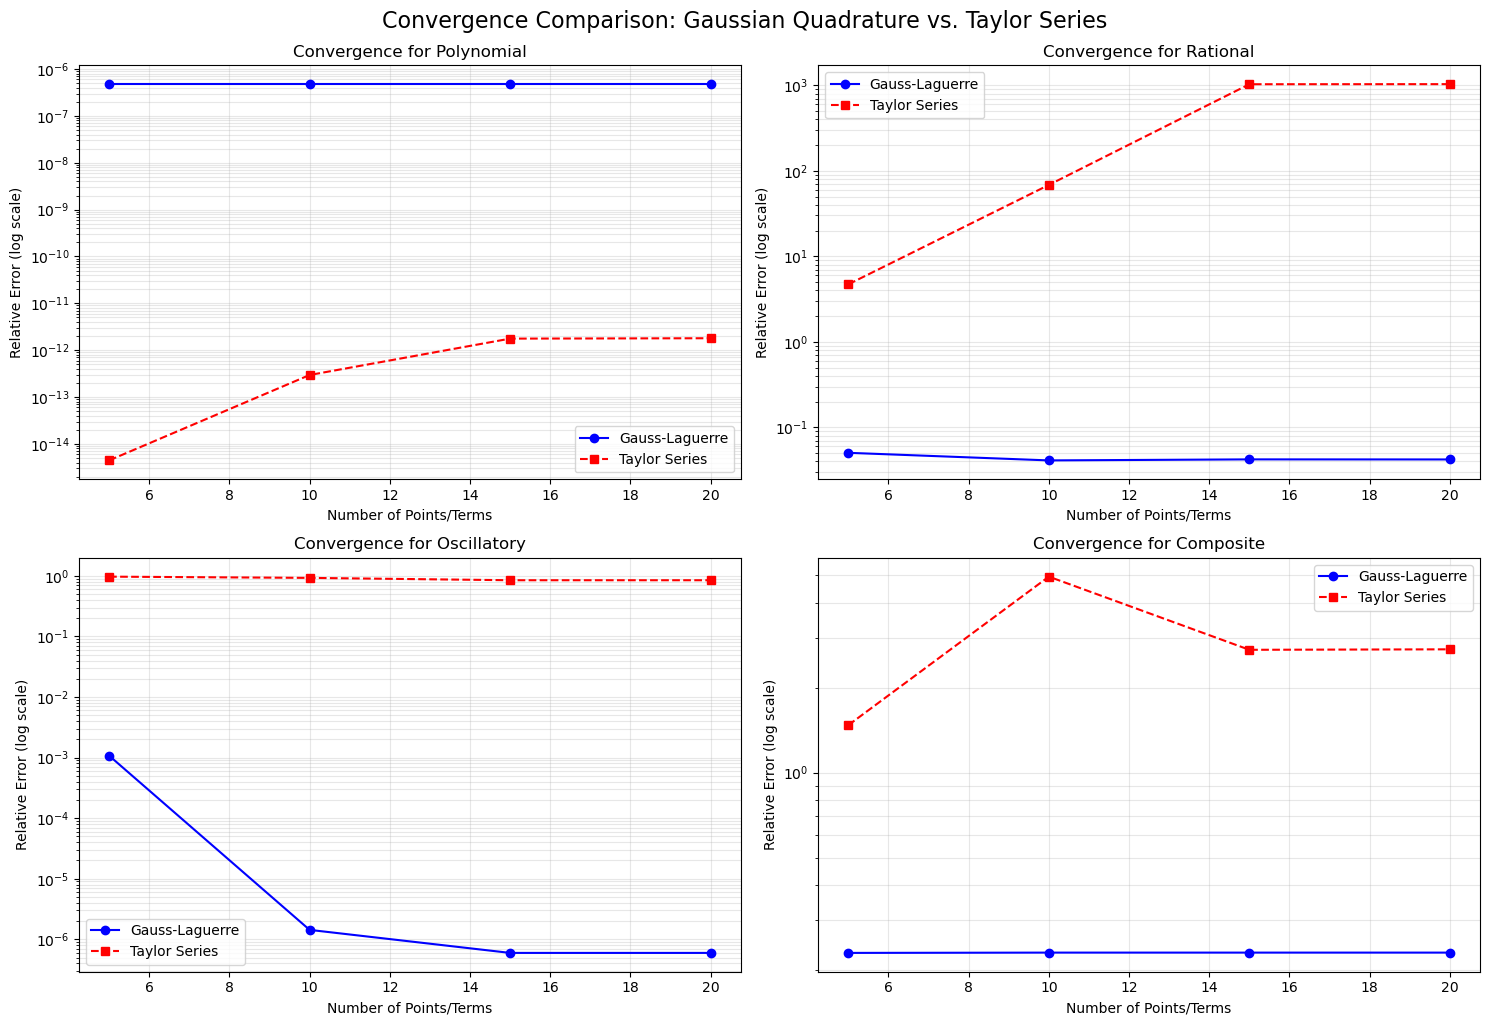

In [52]:
# Plot comparative convergence between Gaussian quadrature and Taylor series
def plot_taylor_comparison(comparison_data):
    plt.figure(figsize=(15, 10))
    
    # Create subplots for each function
    functions = comparison_data['Function'].unique()
    for i, func_name in enumerate(functions, 1):
        plt.subplot(2, 2, i)
        
        # Filter data for this function
        func_data = comparison_data[comparison_data['Function'] == func_name]
        
        # Plot Gauss-Laguerre errors
        plt.semilogy(func_data['Points/Terms'], 
                   func_data['Gauss-Laguerre Rel. Error'], 
                   'b-o', label='Gauss-Laguerre')
        
        # Plot Taylor series errors
        plt.semilogy(func_data['Points/Terms'], 
                   func_data['Taylor Rel. Error'], 
                   'r--s', label='Taylor Series')
        
        plt.title(f'Convergence for {func_name}')
        plt.xlabel('Number of Points/Terms')
        plt.ylabel('Relative Error (log scale)')
        plt.grid(True, which='both', alpha=0.3)
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle('Convergence Comparison: Gaussian Quadrature vs. Taylor Series', y=1.02, fontsize=16)
    plt.show()

# Plot the comparison
plot_taylor_comparison(taylor_comparison)

### 4.8.1 Analysis of Gaussian Quadrature vs. Taylor Series

The comparison between Gaussian quadrature and Taylor series approximation reveals several important insights:

1. **Convergence Behavior**:
   - For simple polynomial functions like $x^2$, both methods converge quickly as they are well-suited to polynomial approximation.
   - For oscillatory functions like $\cos(x)$, Gaussian quadrature generally converges faster than Taylor series, especially for higher degrees.
   - For rational functions like $\frac{1}{1+x^2}$, Taylor series struggles to approximate the behavior far from $x=0$, while Gaussian quadrature maintains good accuracy.

2. **Domain of Applicability**:
   - Taylor series approximation works best for functions that are analytic near the expansion point (x=0) and whose behavior near this point dominates the integral.
   - Gaussian quadrature is more versatile as it adapts to the entire integration domain by optimally placing quadrature points.

3. **Efficiency Considerations**:
   - Computing high-order derivatives for Taylor series can be numerically challenging and computationally expensive.
   - Once Gaussian quadrature points are computed, they can be reused for multiple integrands, making it more efficient for repeated calculations.

4. **Error Characteristics**:
   - Taylor series error typically grows for functions with poor radius of convergence or when behavior far from the expansion point is significant.
   - Gaussian quadrature error is more evenly distributed across the integration domain, making it more robust.

For financial mathematics applications, particularly option pricing with the Bachelier model, Gaussian quadrature offers a more reliable and efficient approach compared to Taylor series expansion, especially when the integrand involves functions that aren't well-approximated by low-order Taylor polynomials near x=0.